# Predict and evaluate SkillsColBERT

In [1]:
# install
# !pip install pytorch-pretrained-bert pytorch-nlp keras scikit-learn matplotlib tensorflow

#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 

In [31]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [32]:
df = pd.read_csv(r'.\data\skills_description.csv', sep='\t', encoding='utf-8')
df = df.rename(columns={'preferredLabel':'query', 'description': 'documents'})
df = df[['query', 'documents']]

df.head()

,query,documents
0,lede musikalsk personale,Tildele og forvalte personaleopgaver på område...
1,føre tilsyn med fængselsprocedurer,Føre tilsyn med driften af et fængsel eller an...
2,anvende antioppressiv praksis,"Identificere undertrykkelse i samfund, økonomi..."
3,kontrollere overensstemmelse med jernbaneforsk...,"Inspicere rullende materiel, komponenter og sy..."
4,identificere tilgængelige tjenester,"Identificere de forskellige tjenester, der er ..."


In [4]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device=="cuda":
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
    print(f'Running on {device} with {n_gpu} number of GPUs')
else:
    print(f'Running on {device}. Be patient...')

Running on cpu. Be patient...


In [5]:
# add special ColBERT tokens to queries and documents
queries = ["[CLS] [Q] " + query + " [SEP]" for query in df['query']]

documents =  ["[CLS] [D] " + query + " [SEP]" for query in df['documents']]

print("Example of query:\n", queries[0])
print("\nExample of document:\n", documents[0])

Example of query:
 [CLS] [Q] lede musikalsk personale [SEP]

Example of document:
 [CLS] [D] Tildele og forvalte personaleopgaver på områder såsom instrumentering, bearbejdning, reproduktion af musik og stemmetræning. [SEP]


In [6]:
# Tokenize with BERT tokenizer
model_path = r'J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish_bert_uncased_v2'
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=True)

#tokenize queries
tokenized_texts = [tokenizer.tokenize(sent) for sent in queries]

# Tokenize documents
tokenized_docs = [tokenizer.tokenize(doc) for doc in documents]

print(f'Tokenize the first sentence: \n {tokenized_texts[0]}')
print (f'\nTokenize the first document: \n {tokenized_docs[0]}')

Tokenize the first sentence: 
 ['[CLS]', '[UNK]', 'q', '[UNK]', 'lede', 'musikalsk', 'personale', '[SEP]']

Tokenize the first document: 
 ['[CLS]', '[UNK]', 'd', '[UNK]', 'tildele', 'og', 'forvalt', '##e', 'personale', '##opgaver', 'pa', 'om', '##rad', '##er', 'sas', '##om', 'instrumenter', '##ing', ',', 'bearbejdning', ',', 'reproduktion', 'af', 'musik', 'og', 'stemme', '##træning', '.', '[SEP]']


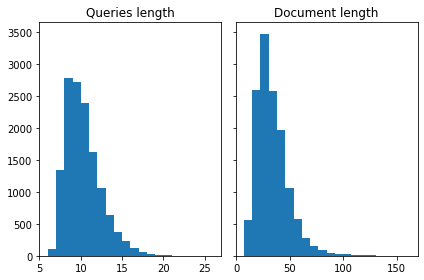

In [7]:
# Length of sequences
len_queries = [len(x) for x in tokenized_texts]
len_documents = [len(x) for x in tokenized_docs]

# Plot length of queries and documents
n_bins = 20

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(len_queries, bins=n_bins)
axs[0].set_title('Queries length',fontsize=12)
axs[1].hist(len_documents, bins=n_bins)
axs[1].set_title('Document length',fontsize=12)
plt.show()

Based on eye-balling the plot we determine to set maximum sequence length of queries to 24 and documents to 128

In [8]:
# Set the maximum query length. 
MAX_LEN_Q = 24

# Pad our input tokens
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
q_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
q_input_ids = pad_sequences(q_input_ids, maxlen=MAX_LEN_Q, dtype="long", truncating="post", padding="post")
print(f'Shape of query ids:\n q_input_ids.shape = {q_input_ids.shape}')

Shape of query ids:
 q_input_ids.shape = (13485, 24)


In [9]:
# Create query attention masks
q_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in q_input_ids:
  seq_mask = [float(i>0) for i in seq]
  q_attention_masks.append(seq_mask)

print(f'Shape of query attention mask:\n q_attention_masks = {np.shape(q_attention_masks)}')

assert q_input_ids.shape == np.shape(q_attention_masks), 'dimensions of q_input_ids and q_attention_mask do not match' 

Shape of query attention mask:
 q_attention_masks = (13485, 24)


In [10]:
# Set the maximum document length. 
MAX_LEN_DOC = 128
# Pad our input tokens
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
d_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_docs]
d_input_ids = pad_sequences(d_input_ids, maxlen=MAX_LEN_DOC, dtype="long", truncating="post", padding="post")
print(f'Shape of input_ids.shape: {d_input_ids.shape}')

Shape of input_ids.shape: (13485, 128)


In [11]:
# Create attention masks for documents
d_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in d_input_ids:
  seq_mask = [float(i>0) for i in seq]
  d_attention_masks.append(seq_mask)

print(f'Shape of d_attention_masks: {np.shape(d_attention_masks)}')

assert d_input_ids.shape == np.shape(d_attention_masks), 'dimensions of document d_input_ids and d_attention_mask do not match' 

Shape of d_attention_masks: (13485, 128)


# Import model
Queries and documents have now been tokenized to the vocabolary

In [12]:
from transformers import BertConfig
from transformers import BertModel

config = BertConfig.from_pretrained(model_path + r'\bert_config.json')
bert_base = BertModel(config)

#param_optimizer = list(bert_base.named_parameters())
#print(bert_base)

In [61]:
from torch import nn
import torch.nn.functional as F

class CustomBERTModel(nn.Module):
    def __init__(self):
          super(CustomBERTModel, self).__init__()
          self.bert = bert_base 
          ### New layers:
          #TODO: self.finalLinear = nn.Linear(768, 32) # 32 is "low" for faster computation of MaxSim (it is independent of sequence lentgh)
          

    def forward(self, ids, mask):
          sequence_output, pooled_output = self.bert(ids, attention_mask=mask) # sequence_output shape is: (batch_size, sequence_length, 768)
               
          # We apply the linear layer in line with ColBERT paper. The linear layer (which applies a linear transformation)
          # takes as input the hidden states of all tokens (so seq_len times a vector of size 768, each corresponding to
          # a single token in the input sequence) and outputs 32 numbers for every token
          # so the logits are of shape (batch_size, sequence_length, 32)
          
          #TODO: sequence_output = self.finalLinear(sequence_output)
          sequence_output = F.softmax(sequence_output, dim=1)

          #linear2_output = self.linear2(linear2_output)

          return sequence_output

In [33]:
# Try model on first 10 query and document pairs
sample_size = 80
np.random.seed(seed=741)
samples = np.random.randint(0,len(df),sample_size)

q_id    = torch.tensor(q_input_ids[:sample_size]).to(torch.device(device)).to(torch.int64)
q_mask  = torch.tensor(q_attention_masks[:sample_size]).to(torch.device(device)).to(torch.int64)

d_id    = torch.tensor(d_input_ids[:sample_size]).to(torch.device(device)).to(torch.int64)
d_mask  = torch.tensor(d_attention_masks[:sample_size]).to(torch.device(device)).to(torch.int64)

In [34]:
#bert_base.to(torch.device(device))
my_model  = CustomBERTModel()
my_model.to(torch.device(device))

# Embeddings of queries
q_outputs = my_model(q_id, mask=q_mask)

# Embeddings of documents
d_outputs = my_model(d_id, mask=d_mask)

#With bert_base shape is: torch.Size([batch_size, 24, 768]) and torch.Size([batch_size, 128, 768])
print('Query embedding size:    ', q_outputs.shape) 
print('Document embedding size: ', d_outputs.shape) 

Query embedding size:     torch.Size([80, 24, 768])
Document embedding size:  torch.Size([80, 128, 768])


In summary, given a query sequence $q = q_0 q_1...q_l$ and a document sequence $d = d_0 d_1...d_n$, we compute the bags of embeddings $E_q$ and $E_d$ in the following manner:

* $E_q$ := Normalize( CNN( BERT(“[Q]$q_0 q_1...q_l$ ##...#”) ) )

* $E_d$ := Normalize( CNN( BERT(“[D]$d_0 d_1...d_l$ ...d_n”) ) )

where '#' refers to the [mask] tokens. In my implementation of ColBERT the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [24 \times 32] \\
    dim(E_d) = [ 128 \times 32]
\end{align*}

\begin{align*}
    dim(E_Q) = [batch_{size} \times 24 \times 32] \\
    dim(E_D) = [batch_{size} \times 128 \times 32]
\end{align*}


The relevancy score, MaxSim, is defined as follows:

$$ S_{q,d} = \sum_{i \in ||E_q||} \max_{j \in ||E_d||} E_{q_i} * E_{d_j}^T$$

In [64]:

def MaxSim(q, D):
    '''Takes in a query, q, and return it's similarity score to
        all documents in  D.'''

    # repeat q for faster matrix multiplication (faster than loop)
    batch_size=D.shape[0]
    q_X = q.repeat(batch_size, 1, 1)
    
    # multiply the same query q against all documents (in D)
    batch_mm = torch.bmm(q_X, D.permute(0,2,1))
    
    maks, _ = torch.max(batch_mm, dim=2) # dim=1 or dim=2
    
    # Sum over maximum values --> return vector of length len(D)
    S_qD = torch.sum(maks, dim=1)
    
    return S_qD

In [76]:
most_similar_doc_score = []
most_similar_docID = []

 # Define D as all documents:
D = d_outputs

for q_no in tqdm(range(sample_size)):
    
    # Select one query
    q = q_outputs[q_no]

    # Compute similarity scores for all 
    S_qD = MaxSim(q, D)
    maks, maks_id = torch.max(S_qD, dim=0)

    most_similar_doc_score.append(float(maks))
    most_similar_docID.append(int(maks_id))

  5%|▌         | 4/80 [00:00<00:01, 38.10it/s]

tensor([[0.0332, 0.0274, 0.0375,  ..., 0.0209, 0.0213, 0.0434],
        [0.0865, 0.0545, 0.0279,  ..., 0.0194, 0.0103, 0.0456],
        [0.0160, 0.0238, 0.0254,  ..., 0.0212, 0.1165, 0.0217],
        ...,
        [0.0136, 0.1002, 0.0356,  ..., 0.0271, 0.0211, 0.1125],
        [0.0411, 0.0476, 0.0150,  ..., 0.0395, 0.0793, 0.0554],
        [0.0224, 0.0586, 0.0180,  ..., 0.0731, 0.0307, 0.0145]],
       grad_fn=<SelectBackward>)
tensor([[0.1870, 0.0243, 0.0752,  ..., 0.0090, 0.0642, 0.0374],
        [0.0303, 0.0226, 0.0330,  ..., 0.0264, 0.0392, 0.0374],
        [0.0105, 0.0153, 0.0443,  ..., 0.0163, 0.0799, 0.0298],
        ...,
        [0.0544, 0.0477, 0.0449,  ..., 0.0422, 0.0263, 0.0955],
        [0.0458, 0.1061, 0.0178,  ..., 0.0537, 0.0697, 0.0670],
        [0.0170, 0.0867, 0.0426,  ..., 0.0192, 0.0241, 0.0198]],
       grad_fn=<SelectBackward>)
tensor([[0.0588, 0.0147, 0.0745,  ..., 0.0172, 0.0116, 0.0795],
        [0.0320, 0.0407, 0.0230,  ..., 0.0233, 0.0172, 0.0126],
        [0

 16%|█▋        | 13/80 [00:00<00:01, 38.51it/s]


tensor([[0.1031, 0.0192, 0.0690,  ..., 0.0330, 0.0350, 0.0541],
        [0.0262, 0.0168, 0.0538,  ..., 0.0195, 0.0181, 0.0272],
        [0.0105, 0.0227, 0.0534,  ..., 0.0270, 0.0413, 0.0209],
        ...,
        [0.0977, 0.0834, 0.0183,  ..., 0.0191, 0.0792, 0.0668],
        [0.0449, 0.0683, 0.0142,  ..., 0.0592, 0.0524, 0.0431],
        [0.0181, 0.0651, 0.0487,  ..., 0.0610, 0.0304, 0.0272]],
       grad_fn=<SelectBackward>)
tensor([[0.0907, 0.0339, 0.0367,  ..., 0.0245, 0.0282, 0.0794],
        [0.0610, 0.0419, 0.0405,  ..., 0.0347, 0.0201, 0.0228],
        [0.0231, 0.0183, 0.0482,  ..., 0.0320, 0.0450, 0.0268],
        ...,
        [0.0286, 0.0597, 0.0218,  ..., 0.0271, 0.0242, 0.0857],
        [0.0335, 0.0831, 0.0150,  ..., 0.0692, 0.0568, 0.0608],
        [0.0741, 0.0168, 0.0449,  ..., 0.0612, 0.0520, 0.0422]],
       grad_fn=<SelectBackward>)
tensor([[0.0719, 0.0242, 0.0798,  ..., 0.0209, 0.0166, 0.0768],
        [0.0176, 0.0194, 0.0147,  ..., 0.0744, 0.0177, 0.0444],
        [

 29%|██▉       | 23/80 [00:00<00:01, 41.90it/s]


tensor([[0.1012, 0.0173, 0.0252,  ..., 0.0412, 0.0353, 0.0624],
        [0.0737, 0.0442, 0.0269,  ..., 0.0233, 0.0364, 0.0168],
        [0.0120, 0.0244, 0.0330,  ..., 0.0181, 0.0528, 0.0073],
        ...,
        [0.0425, 0.0385, 0.0563,  ..., 0.0343, 0.0288, 0.0734],
        [0.0650, 0.0705, 0.0431,  ..., 0.0308, 0.0633, 0.0441],
        [0.0198, 0.0316, 0.0280,  ..., 0.0361, 0.0453, 0.0445]],
       grad_fn=<SelectBackward>)
tensor([[0.0636, 0.0109, 0.1164,  ..., 0.0090, 0.0306, 0.0238],
        [0.0494, 0.0805, 0.0263,  ..., 0.0527, 0.0238, 0.0647],
        [0.0084, 0.0210, 0.0541,  ..., 0.0424, 0.0461, 0.0078],
        ...,
        [0.0356, 0.1962, 0.0378,  ..., 0.0626, 0.0258, 0.1045],
        [0.0437, 0.0460, 0.0268,  ..., 0.0456, 0.0214, 0.1028],
        [0.0296, 0.0790, 0.0368,  ..., 0.0493, 0.0957, 0.0466]],
       grad_fn=<SelectBackward>)
tensor([[0.1230, 0.0175, 0.0701,  ..., 0.0249, 0.0273, 0.0816],
        [0.0112, 0.0511, 0.0609,  ..., 0.0291, 0.0290, 0.0302],
        [

 36%|███▋      | 29/80 [00:00<00:01, 44.77it/s]


tensor([[0.0562, 0.0145, 0.0546,  ..., 0.0116, 0.0209, 0.1657],
        [0.0335, 0.0438, 0.0215,  ..., 0.0202, 0.0324, 0.0153],
        [0.0076, 0.0359, 0.0690,  ..., 0.0104, 0.0567, 0.0132],
        ...,
        [0.0269, 0.0351, 0.0571,  ..., 0.0290, 0.0450, 0.1539],
        [0.0190, 0.0292, 0.0178,  ..., 0.0599, 0.0913, 0.0399],
        [0.1073, 0.0987, 0.0768,  ..., 0.0314, 0.0442, 0.0336]],
       grad_fn=<SelectBackward>)
tensor([[0.1060, 0.0569, 0.0610,  ..., 0.0160, 0.0306, 0.0625],
        [0.0234, 0.0296, 0.0174,  ..., 0.0215, 0.0194, 0.0260],
        [0.0116, 0.0375, 0.0355,  ..., 0.0186, 0.0549, 0.0083],
        ...,
        [0.0347, 0.1209, 0.0329,  ..., 0.0431, 0.0304, 0.0509],
        [0.0432, 0.0598, 0.0155,  ..., 0.0653, 0.0292, 0.0421],
        [0.0253, 0.0628, 0.0566,  ..., 0.0682, 0.0462, 0.0347]],
       grad_fn=<SelectBackward>)
tensor([[0.0545, 0.0243, 0.0559,  ..., 0.0243, 0.0319, 0.0418],
        [0.0215, 0.0923, 0.0312,  ..., 0.0534, 0.0084, 0.0239],
        [

 49%|████▉     | 39/80 [00:00<00:00, 44.45it/s]

tensor([[0.0965, 0.0214, 0.0836,  ..., 0.0148, 0.0350, 0.0344],
        [0.0761, 0.0443, 0.0397,  ..., 0.0283, 0.0148, 0.0222],
        [0.0127, 0.0161, 0.0409,  ..., 0.0165, 0.0500, 0.0235],
        ...,
        [0.0134, 0.0786, 0.0763,  ..., 0.0263, 0.0388, 0.0666],
        [0.0318, 0.0477, 0.0122,  ..., 0.0547, 0.0535, 0.0592],
        [0.0550, 0.0471, 0.0229,  ..., 0.0722, 0.0500, 0.0479]],
       grad_fn=<SelectBackward>)
tensor([[0.0891, 0.0255, 0.0902,  ..., 0.0279, 0.0227, 0.0591],
        [0.0152, 0.0560, 0.0174,  ..., 0.0735, 0.0207, 0.0208],
        [0.0042, 0.0402, 0.0298,  ..., 0.0125, 0.0547, 0.0340],
        ...,
        [0.0474, 0.0263, 0.0839,  ..., 0.0197, 0.0386, 0.0823],
        [0.0268, 0.0468, 0.0196,  ..., 0.0377, 0.0466, 0.0628],
        [0.0547, 0.1114, 0.0511,  ..., 0.0413, 0.0538, 0.0368]],
       grad_fn=<SelectBackward>)
tensor([[0.0624, 0.0178, 0.0430,  ..., 0.0148, 0.0261, 0.0373],
        [0.0212, 0.0381, 0.0367,  ..., 0.0260, 0.0360, 0.0357],
        [0

 57%|█████▊    | 46/80 [00:01<00:00, 50.44it/s]


tensor([[0.1114, 0.0247, 0.1001,  ..., 0.0231, 0.0139, 0.0533],
        [0.0170, 0.0382, 0.0370,  ..., 0.0204, 0.0209, 0.0553],
        [0.0105, 0.0251, 0.0356,  ..., 0.0234, 0.0636, 0.0203],
        ...,
        [0.0579, 0.0561, 0.0519,  ..., 0.0203, 0.0260, 0.0697],
        [0.0317, 0.0791, 0.0158,  ..., 0.0692, 0.0980, 0.0664],
        [0.0547, 0.0211, 0.0490,  ..., 0.0687, 0.0462, 0.0740]],
       grad_fn=<SelectBackward>)
tensor([[0.0755, 0.0231, 0.0517,  ..., 0.0320, 0.0217, 0.0415],
        [0.0338, 0.0217, 0.0256,  ..., 0.0414, 0.0204, 0.0614],
        [0.0274, 0.0161, 0.0505,  ..., 0.0156, 0.0259, 0.0255],
        ...,
        [0.0377, 0.0719, 0.0661,  ..., 0.0242, 0.0188, 0.0566],
        [0.0448, 0.0234, 0.0188,  ..., 0.0628, 0.0360, 0.0527],
        [0.0764, 0.0616, 0.0289,  ..., 0.0176, 0.0454, 0.0663]],
       grad_fn=<SelectBackward>)
tensor([[0.1089, 0.0290, 0.0703,  ..., 0.0217, 0.0212, 0.0701],
        [0.0442, 0.0263, 0.0505,  ..., 0.0266, 0.0218, 0.0581],
        [

 65%|██████▌   | 52/80 [00:01<00:00, 44.35it/s]


tensor([[0.0907, 0.0217, 0.0836,  ..., 0.0188, 0.0158, 0.0983],
        [0.0337, 0.0483, 0.0465,  ..., 0.0182, 0.0517, 0.0119],
        [0.0171, 0.0186, 0.0421,  ..., 0.0199, 0.0491, 0.0145],
        ...,
        [0.0258, 0.1135, 0.0304,  ..., 0.0186, 0.0329, 0.0620],
        [0.0542, 0.0516, 0.0176,  ..., 0.0728, 0.0327, 0.0782],
        [0.0245, 0.1639, 0.0484,  ..., 0.0474, 0.0713, 0.0252]],
       grad_fn=<SelectBackward>)
tensor([[0.0694, 0.0244, 0.0736,  ..., 0.0354, 0.0101, 0.0455],
        [0.0319, 0.0214, 0.0373,  ..., 0.0079, 0.0790, 0.0756],
        [0.0154, 0.0153, 0.0645,  ..., 0.0113, 0.0784, 0.0156],
        ...,
        [0.0810, 0.0893, 0.0399,  ..., 0.0478, 0.0199, 0.1409],
        [0.0326, 0.0688, 0.0153,  ..., 0.0600, 0.0476, 0.0447],
        [0.0208, 0.1086, 0.0243,  ..., 0.0434, 0.0381, 0.0399]],
       grad_fn=<SelectBackward>)
tensor([[0.0386, 0.0246, 0.0743,  ..., 0.0408, 0.0351, 0.0688],
        [0.0362, 0.0474, 0.0426,  ..., 0.0227, 0.0314, 0.0448],
        [

 78%|███████▊  | 62/80 [00:01<00:00, 40.17it/s]

tensor([[0.1441, 0.0068, 0.1256,  ..., 0.0175, 0.0466, 0.0423],
        [0.0526, 0.0175, 0.0309,  ..., 0.0403, 0.0104, 0.0241],
        [0.0080, 0.0356, 0.0234,  ..., 0.0119, 0.0268, 0.0168],
        ...,
        [0.0262, 0.0592, 0.0159,  ..., 0.0221, 0.0549, 0.1302],
        [0.0457, 0.0576, 0.0198,  ..., 0.0465, 0.0524, 0.0910],
        [0.0660, 0.0245, 0.0473,  ..., 0.0471, 0.0415, 0.0642]],
       grad_fn=<SelectBackward>)
tensor([[0.0334, 0.0153, 0.0909,  ..., 0.0400, 0.0155, 0.0986],
        [0.0287, 0.0560, 0.0201,  ..., 0.0614, 0.0157, 0.0199],
        [0.0118, 0.0182, 0.0284,  ..., 0.0333, 0.0632, 0.0130],
        ...,
        [0.0478, 0.1642, 0.0694,  ..., 0.0281, 0.0316, 0.1430],
        [0.0671, 0.0745, 0.0305,  ..., 0.0313, 0.1053, 0.0615],
        [0.0428, 0.0296, 0.0383,  ..., 0.0358, 0.0454, 0.0525]],
       grad_fn=<SelectBackward>)
tensor([[0.0753, 0.0256, 0.0592,  ..., 0.0248, 0.0355, 0.0546],
        [0.0181, 0.0247, 0.0230,  ..., 0.0335, 0.0258, 0.0576],
        [0

 92%|█████████▎| 74/80 [00:01<00:00, 47.22it/s]


tensor([[0.0479, 0.0281, 0.0586,  ..., 0.0442, 0.0511, 0.0634],
        [0.0224, 0.0277, 0.0546,  ..., 0.0287, 0.0245, 0.0496],
        [0.0065, 0.0236, 0.0224,  ..., 0.0227, 0.0672, 0.0094],
        ...,
        [0.0586, 0.1233, 0.0725,  ..., 0.0536, 0.0496, 0.1074],
        [0.0408, 0.0622, 0.0322,  ..., 0.0941, 0.0353, 0.0462],
        [0.0424, 0.0662, 0.0282,  ..., 0.0456, 0.0406, 0.0213]],
       grad_fn=<SelectBackward>)
tensor([[0.0536, 0.0087, 0.0731,  ..., 0.0121, 0.0299, 0.0841],
        [0.0212, 0.0367, 0.0403,  ..., 0.0373, 0.0096, 0.0280],
        [0.0052, 0.0118, 0.0319,  ..., 0.0147, 0.0556, 0.0164],
        ...,
        [0.0215, 0.1177, 0.0568,  ..., 0.0568, 0.0325, 0.0551],
        [0.1206, 0.0520, 0.0125,  ..., 0.0215, 0.0293, 0.0423],
        [0.0752, 0.0977, 0.0456,  ..., 0.0517, 0.0605, 0.0181]],
       grad_fn=<SelectBackward>)
tensor([[0.0836, 0.0335, 0.0658,  ..., 0.0392, 0.0290, 0.0603],
        [0.0198, 0.0489, 0.0172,  ..., 0.0180, 0.0180, 0.0280],
        [

100%|██████████| 80/80 [00:01<00:00, 45.28it/s]


tensor([[0.1089, 0.0178, 0.0393,  ..., 0.0754, 0.0283, 0.0867],
        [0.0248, 0.0167, 0.0604,  ..., 0.0162, 0.0335, 0.0308],
        [0.0247, 0.0211, 0.0740,  ..., 0.0173, 0.0518, 0.0066],
        ...,
        [0.0537, 0.0893, 0.0548,  ..., 0.0304, 0.0322, 0.0710],
        [0.0487, 0.0780, 0.0171,  ..., 0.0326, 0.0695, 0.0540],
        [0.0511, 0.0612, 0.0610,  ..., 0.0708, 0.0397, 0.0379]],
       grad_fn=<SelectBackward>)
tensor([[0.0674, 0.0364, 0.0923,  ..., 0.0102, 0.0225, 0.1017],
        [0.0153, 0.0388, 0.0235,  ..., 0.0211, 0.0207, 0.0329],
        [0.0219, 0.0207, 0.0313,  ..., 0.0165, 0.1248, 0.0121],
        ...,
        [0.0431, 0.1735, 0.0696,  ..., 0.0775, 0.0401, 0.0834],
        [0.0335, 0.0244, 0.0163,  ..., 0.0558, 0.0261, 0.0534],
        [0.0233, 0.0474, 0.0456,  ..., 0.0430, 0.0463, 0.0775]],
       grad_fn=<SelectBackward>)


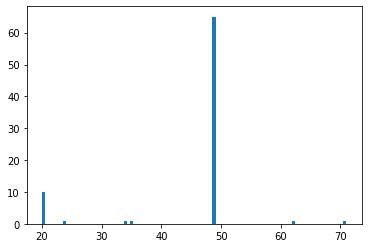

In [77]:
# Distribution of "predictions"
plt.hist(most_similar_docID, bins=100)
plt.show()

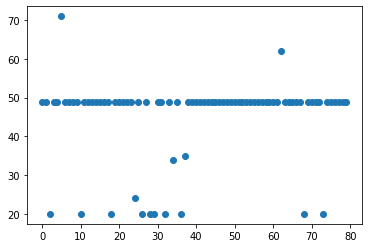

In [67]:
# Distribution of "predictions"
q_IDs = [x for x in range(sample_size)]
plt.scatter(q_IDs, most_similar_docID)
plt.show()

In [68]:
from sklearn.metrics import f1_score
y_true = q_IDs
y_pred = most_similar_docID
f1_score(y_true, y_pred, average='macro')

0.03787878787878788

In [73]:
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

print(f'rights: {rights} out of {rights+wrongs} \n {rights/(rights+wrongs)}% accuracy')

rights: 4 out of 80 
 0.05% accuracy


In [74]:
df_check = df.iloc[:sample_size,:].loc[(np.array(y_true) == np.array(y_pred))]
df_check

,query,documents
24,udnytte avancerede kliniske kompetencer,Anvende avancerede kliniske kompetencer i best...
34,udvikle et genoptræningsprogram,Udvikle et genoptræningsprogram med henblik på...
49,foretage indkøb af reservedele,Bestille særlige dele til vedligeholdelse og r...
62,bruge værktøj til glasindgravering,"Bruge værktøj til gravering, som anvender stål..."


In [75]:
df.documents[49]

'Bestille særlige dele til vedligeholdelse og reparation af en lang række køretøjer.'